In [1]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib

import analyze2p.objects.selectivity as sel
import analyze2p.objects.sim_utils as su

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [3]:
experiment = 'blobs'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)
#### Responsive params
responsive_str = '%s_%s-%.2f' % (response_type, responsive_test, responsive_thr)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'blobs_%s_%s' % (response_type, responsive_test),
                       'morph_tuning')
print(dst_dir)

ROC 0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning


# Load data

In [4]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [5]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1252 |
| Lm |          1035 |
| Li |           577 |
|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            16 |
| V1 |            15 |


In [6]:
counts = aggr.count_n_cells(CELLS, name='n_cells', reset_index=True)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       577 |
| Lm            |      1035 |
| V1            |      1252 |
[V1] Animalid does not exist: JC078 
FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       397 |        13 |
| Lm            |       643 |        10 |
| V1            |      1031 |         9 |


In [7]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA['datakey'].unique(), experiment='blobs',
                        images_only=False, rename=True,
                        return_incorrect=True, return_all=False)

In [8]:
incorrect_stim.keys()

dict_keys(['20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1'])

In [9]:
response_type='dff'
do_spherical_correction=False
# ------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
print(rf_str)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
rfs-dff-uncorr


In [10]:
rf_fit_desc

'fit-2dgaus_dff-no-cutoff'

In [11]:
print(rf_fit_desc)
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

fit-2dgaus_dff-no-cutoff


# Tuning curves

In [12]:

data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)
                       
print(dst_dir)
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
print(FIGDIR)

traces001|dff_ROC-0.05|rfs-dff-uncorr
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES


In [13]:
examples_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(examples_dir):
    os.makedirs(examples_dir)
print(examples_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples


In [14]:
va='V1'
dk='20190616_JC097_fov1'
offset_type='minsub' 
lcorrection='exclude'
with_lum = False

sdf = aggr.get_stimuli(dk, experiment, match_names=True)
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))
morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
print(morphlevels)

x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
          & (NDATA0.config.isin(configs))].copy()
rdf0 = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
rdf.head()

[0, 14, 27, 40, 53, 66, 79, 92, 106]


,cell,config,response,size,morphlevel
0,0,config006,0.073549,10.0,0
1,0,config007,0.062874,20.0,0
2,0,config008,0.089596,30.0,0
3,0,config009,0.102889,40.0,0
4,0,config010,0.181599,50.0,0


In [15]:
ixs_ = sel.calculate_metrics(rdf[rdf.config.isin(configs)], sdf)
ixs_['visual_area'] = va
ixs_['datakey'] = dk


In [16]:
# morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=True,
#                                                 normalize=True, return_stacked=True)
# morph_curves.head()

In [17]:
#### Generate tuning curves
morph_curves, size_curves = sel.get_object_tuning_curves(rdf, sort_best_size=True,
                                                normalize=True, return_stacked=True)

#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(sel.assign_morph_ix, 
                                        at_best_other=True, name='morph_sel')
morph_ixs.index = morph_ixs.index.droplevel(1)
sorted_morph_ixs = morph_ixs.sort_values(by='morph_sel', ascending=False)
#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(sel.assign_size_tolerance, 
                                        at_best_other=True, name='size_tol')
size_tols.index = size_tols.index.droplevel(1)
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)

#### Aggregate
best_ixs = pd.concat([size_tols, morph_ixs], axis=1).reset_index()
best_ixs.index=best_ixs['cell']
best_ixs.head()

,cell,size_tol,best_morphlevel,morph_sel,best_size
cell,,,,,
0,0,0.452792,0.0,0.605266,50.0
1,1,0.447143,53.0,0.175861,50.0
2,2,0.421139,53.0,0.515437,50.0
9,9,0.362837,14.0,0.360534,20.0
11,11,0.381669,79.0,0.319997,10.0


<IPython.core.display.Javascript object>


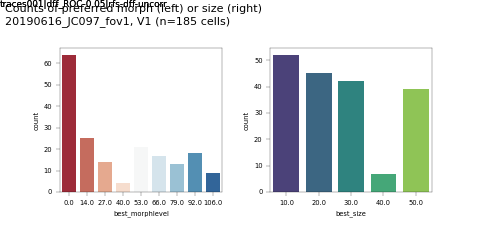

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [19]:
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
sns.countplot(x='best_morphlevel', data=best_ixs, ax=ax, palette='RdBu')
# ax.set_xticks(morphlevels)
ax=axn[1]
sns.countplot(x='best_size', data=best_ixs, ax=ax, palette='viridis')
n_cells = len(best_ixs['cell'].unique())
fig.text(0.01, 0.9, \
        'Counts of preferred morph (left) or size (right)\n%s, %s (n=%i cells)'\
         % (dk, va, n_cells))
pl.subplots_adjust(top=0.8, bottom=0.2, wspace=0.3)

pplot.label_figure(fig, data_id)
figname = 'distn_pref_morphs_and_sizes__%s_%s' % (va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


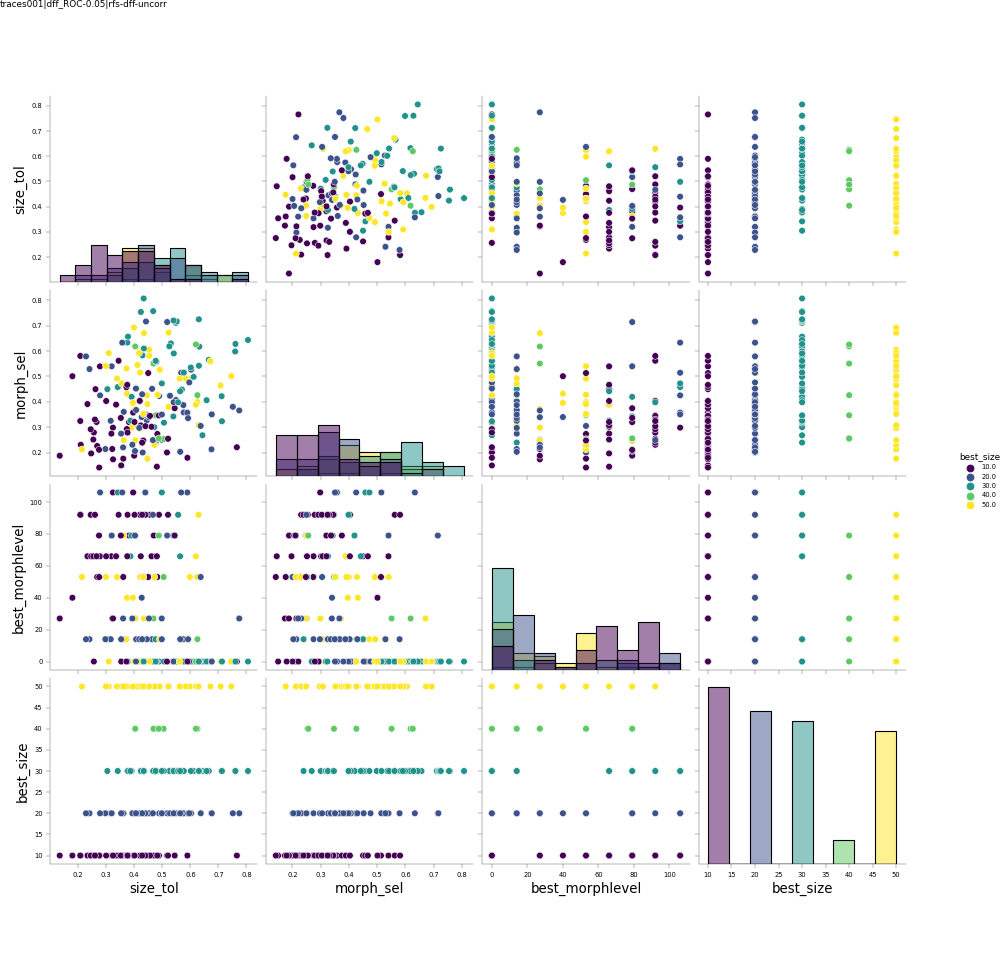

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples selectivity_metrics_hue-best_size__V1_20190616_JC097_fov1


In [20]:
hue_param='best_size'
palette='viridis' if hue_param=='best_size' else 'RdBu'
fg = sns.pairplot(best_ixs, hue=hue_param, height=3, palette=palette,
                  vars=['size_tol', 'morph_sel', 'best_morphlevel', 'best_size'],
                  diag_kind='hist', diag_kws=dict(stat='probability', ecolor='w'))
fg.fig.patch.set_alpha(1)
for ax in fg.fig.axes:
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    
pl.subplots_adjust(left=0.05, right=0.9, bottom=0.1, top=0.9)
pplot.label_figure(fig, data_id)

pplot.label_figure(fg.fig, data_id)
figname = 'selectivity_metrics_hue-%s__%s_%s' % (hue_param, va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

In [170]:
roi_labels = ['high', 'low'] # 'all']
roi_colors = ['cornflowerblue',  'orange'] #, 'k']
roi_styles = ['-', '-']
size_labels = [int(s) for s in sorted(sdf['size'].unique())]
morph_labels = [int(s) for s in sorted(sdf['morphlevel'].unique())]
rank_order=False
lw=0.25
rois_plot_mp = [217, 388] 
rois_plot_sz = [217, 388]

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples aggr_tuning_curves_rid217_388__V1_20190616_JC097_fov1


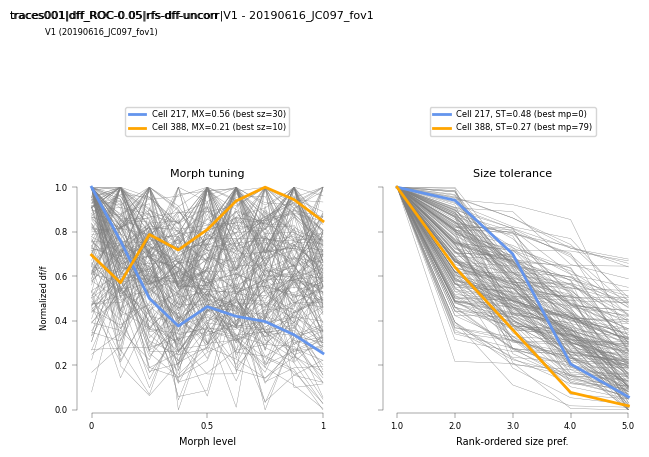

In [171]:
%matplotlib inline

fig, axn = pl.subplots(1,2, figsize=(7,5), dpi=100,sharey=True)
ax=axn[0]
rank_order=False
if rank_order:
    xx = morph_mat.copy()
    xx.values.sort(axis=0)
    mm = xx[::-1]
else:
    mm = morph_mat.copy()
ax.plot(mm.values, color='gray', alpha=1, lw=lw)
ax.set_title("Morph tuning")
for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['best_size'].unique())
    ax.plot(mm[rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, MX=%.2f (best sz=%i)' 
            % (rid, best_ixs.loc[rid]['morph_sel'], best_sz))
xlabel = 'Rank-ordered morphs' if rank_order else 'Morph level' 
xtick_ixs = np.linspace(0, len(morph_labels)-2, 3, endpoint=True)
ax.set_xticks(xtick_ixs)
xticks = xtick_ixs+1 if rank_order else [0, 0.5, 1]
ax.set_xticklabels(xticks)
ax.set_xlabel(xlabel, fontsize=7)
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)
ax.set_ylim([0, 1])
# Size Tolerance
ax=axn[1]
rank_order=True
if rank_order:
    xx = size_mat.copy()
    xx.values.sort(axis=0) #[::-1]
    sz = xx[::-1]
else:
    sz = size_mat.copy()
    
ax.plot(sz.values, color='gray', alpha=1, lw=lw)
ax.set_title("Size tolerance")

for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['best_morphlevel'].unique())
    ax.plot(sz[rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, ST=%.2f (best mp=%i)'
            % (rid, best_ixs.loc[rid]['size_tol'], best_mp))
xlabel = 'Rank-ordered size pref.' if rank_order else 'Size (deg)'
xticks = np.arange(0, len(size_labels)) if rank_order else size_labels
xtick_labels = np.linspace(1, len(size_labels), len(size_labels))\
                    if rank_order else size_labels
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

ax.set_xlabel(xlabel, fontsize=7)
ax.set_ylim([0, 1.01])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=6)

sns.despine(offset=2, trim=True)
axn[0].set_ylabel('Normalized df/f')
fig.text(0.05, 0.95, '%s (%s)' % (va, dk), fontsize=6)

pplot.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
pl.subplots_adjust(wspace=0.2, left=0.1, right=0.9, top=0.65, bottom=0.2)


pplot.label_figure(fig, data_id)
figname = 'aggr_tuning_curves_rid%i_%i__%s_%s' % (r1, r2, va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

#### Test tuning metrics

In [55]:
from scipy import signal

In [165]:
%matplotlib notebook
r1, r2 = rois_plot_mp
print(r1, r2)
# r1 =0
# r2= 65
stim_param = 'size'
morph_mat, size_mat = sel.get_object_tuning_curves(rdf, 
                                        sort_best_size=True, normalize=True)
val_mat = morph_mat.copy() if stim_param=='morph' else size_mat.copy()
    
curve1 = val_mat[r1].values
curve2 = val_mat[r2].values

levels = val_mat[r2].index.to_numpy() #.values
levels

217 388


array([1., 2., 3., 4., 5.])

<IPython.core.display.Javascript object>


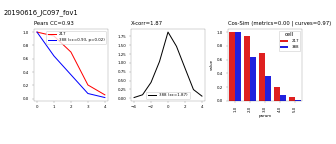

Text(0.01, 0.9, '20190616_JC097_fov1')

In [166]:
# r2 = 116
#r2 = 281
c1='r'
c2='b'
roi_colors={r1: c1, r2: c2}

fig, axn = pl.subplots(1,3, figsize=(7,3))
ax=axn[0]
ax.plot(curve1, label=r1, color=c1)
cc, pv = spstats.pearsonr(curve1, curve2)
axn[0].plot(curve2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv), color=c2)
axn[0].set_title('Pears CC=%.2f' % cc, loc='left', fontsize=8)
axn[0].legend()

ccorr = signal.correlate(curve1, curve2)
lags = signal.correlation_lags(len(curve1), len(curve1))

#ax.legend()
lagzero = list(lags).index(0)
xcorr = ccorr[lagzero]
axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr), color='k')
axn[1].set_title('X-corr=%.2f' % xcorr, loc='left', fontsize=8)
axn[1].legend()
# --------------------------------------
ax=axn[2]
cosim_c = cr.cosine_similarity(curve1, curve2)
# d0, cosim_m = cr.get_paired_tuning_metrics(fitdf, r1, r2)
d1 = pd.DataFrame({'param': levels, 'value': curve1})
d1['cell']=r1
d2 = pd.DataFrame({'param':  levels, 'value': curve2})
d2['cell']=r2
d0 = pd.concat([d1, d2], axis=0)
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True, palette=roi_colors)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)
cosim_m=0
ax.set_title('Cos-Sim (metrics=%.2f | curves=%.2f)' % (cosim_m, cosim_c), 
            loc='left', fontsize=8)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, wspace=0.3, top=0.8)

fig.text(0.01, 0.9, dk)

## Visualize: plot tuning curves

In [178]:
x0['morphlevel'] = sdf.loc[x0.config.values]['morphlevel'].values
x0['size'] = sdf.loc[x0.config.values]['size'].values
x0.head()

,datakey,config,trial,visual_area,cell,response,experiment,morphlevel,size
1,20190616_JC097_fov1,config023,2,V1,0,0.045070,blobs,40,30.0
2,20190616_JC097_fov1,config016,3,V1,0,-0.125729,blobs,27,10.0
3,20190616_JC097_fov1,config012,4,V1,0,0.045203,blobs,14,20.0
5,20190616_JC097_fov1,config032,6,V1,0,-0.042532,blobs,66,20.0
6,20190616_JC097_fov1,config042,7,V1,0,0.088752,blobs,92,20.0


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples tuning_curves_rid217_388__V1_20190616_JC097_fov1


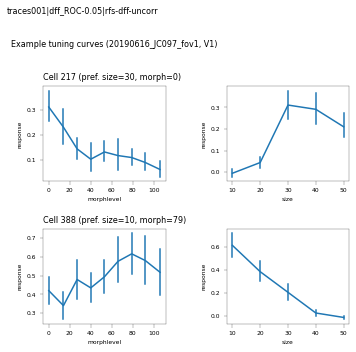

In [185]:
fig, axn = pl.subplots(2,2, figsize=(5,5.5))
fig.patch.set_alpha(1)
for ai, rid in enumerate(rois_plot_mp):
    roi_resp = x0[(x0.cell==rid)].copy()
    best_sz = best_ixs.loc[rid]['best_size']
    best_mp = best_ixs.loc[rid]['best_morphlevel']
    # plot
    ax=axn[ai, 0]
    sns.lineplot(x='morphlevel', y='response', ax=ax,
                 data=roi_resp[roi_resp['size']==best_sz], err_style='bars')
    ax.set_title('Cell %i (pref. size=%i, morph=%i)' % (rid, best_sz, best_mp), 
                 loc='left', fontsize=8)
    ax=axn[ai, 1]
    sns.lineplot(x='size', y='response',  ax=ax,
                data=roi_resp[roi_resp['morphlevel']==best_mp], err_style='bars')

fig.text(0.01, 0.9, 'Example tuning curves (%s, %s)' % (dk, va), fontsize=8)
pl.subplots_adjust(left=0.1, right=0.95,bottom=0.2, wspace=0.5, top=0.8, hspace=0.5)


pplot.label_figure(fig, data_id)
figname = 'tuning_curves_rid%i_%i__%s_%s' % (r1, r2, va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

In [80]:
# DISTS[(DISTS.visual_area==va) & (DISTS.datakey==dk) 
#      & (DISTS.neuron_pair=='%i_%i' % (r1, r2))]

In [341]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [342]:
rois_ = rdf['cell'].unique()
col_pairs = list(itertools.combinations(rois_, 2))  

In [21]:
# cc = cr.get_pw_tuning(rdf, stimulus='blobs')
tuning_dists = cr.correlate_pw_tuning_in_fov(rdf, stimulus='blobs',
                                sort_best_size=True, normalize=True)
n_pairs=len(tuning_dists['neuron_pair'].unique())
tuning_dists.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response
0,3.502203,-0.030559,0.876929,0.0,1.0,0_1,1.900788,0.848862,0.958029,0.026044
1,2.839756,0.780673,0.942752,0.0,2.0,0_2,1.832618,0.920442,0.977413,0.066998
2,3.129756,0.676105,0.936768,0.0,9.0,0_9,1.694492,0.994842,0.991813,0.122524
3,2.824641,-0.381755,0.813232,0.0,11.0,0_11,1.768774,0.915901,0.965303,0.036876
4,2.598988,0.200115,0.860275,0.0,12.0,0_12,2.073319,0.958303,0.991609,0.126501


In [24]:
tuning_dists_nosort = cr.correlate_pw_tuning_in_fov(rdf, stimulus='blobs',
                                sort_best_size=False, normalize=True)

tuning_dists_nonorm = cr.correlate_pw_tuning_in_fov(rdf, stimulus='blobs',
                                sort_best_size=True, normalize=False)

In [25]:
tuning_dists['condition'] = 'sort_and_normalize'
tuning_dists_nosort['condition'] = 'no_sort'
tuning_dists_nonorm['condition'] = 'no_norm'

testdf = pd.concat([tuning_dists, tuning_dists_nosort, tuning_dists_nonorm], axis=0)


In [28]:
testdf

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response,condition
0,3.502203,-0.030559,0.876929,0.0,1.0,0_1,1.900788,0.848862,0.958029,0.026044,sort_and_normalize
1,2.839756,0.780673,0.942752,0.0,2.0,0_2,1.832618,0.920442,0.977413,0.066998,sort_and_normalize
2,3.129756,0.676105,0.936768,0.0,9.0,0_9,1.694492,0.994842,0.991813,0.122524,sort_and_normalize
3,2.824641,-0.381755,0.813232,0.0,11.0,0_11,1.768774,0.915901,0.965303,0.036876,sort_and_normalize
4,2.598988,0.200115,0.860275,0.0,12.0,0_12,2.073319,0.958303,0.991609,0.126501,sort_and_normalize
...,...,...,...,...,...,...,...,...,...,...,...
17015,0.024302,-0.024997,0.913554,425.0,429.0,425_429,0.012696,0.978363,0.973227,0.073083,no_norm
17016,0.024760,-0.632097,0.855734,425.0,431.0,425_431,0.009581,0.938359,0.858021,0.070943,no_norm
17017,0.012616,0.200581,0.949356,426.0,429.0,426_429,0.005103,0.826882,0.961683,0.007518,no_norm
17018,0.013505,0.006307,0.934259,426.0,431.0,426_431,0.004108,0.783039,0.904344,0.005378,no_norm


In [ ]:
tuning_dists

<IPython.core.display.Javascript object>


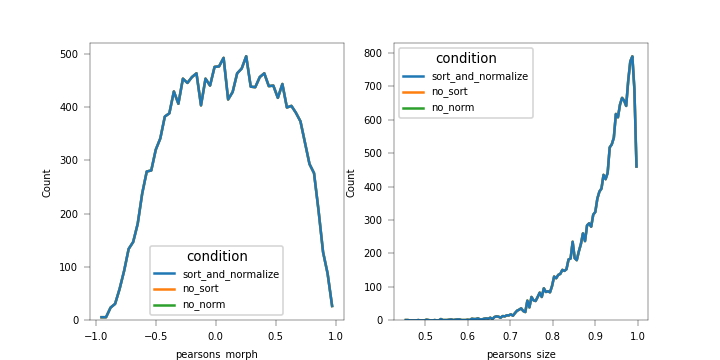

<AxesSubplot:xlabel='pearsons_size', ylabel='Count'>

In [32]:
metric ='pearsons'
fig, axn = pl.subplots(1,2,  figsize=(6,3), dpi=150)
ax=axn[0]
sns.histplot(x='%s_morph' % metric,hue='condition', data=testdf, ax=ax,
            fill=False, element='poly')
ax=axn[1]
sns.histplot(x='%s_size' % metric,hue='condition', data=testdf, ax=ax,
             fill=False, element='poly')



<IPython.core.display.Javascript object>


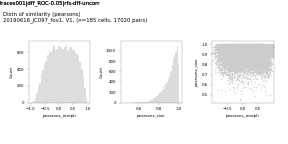

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples distn_pearsons__V1_20190616_JC097_fov1


In [345]:
metric = 'pearsons'
fig, axn = pl.subplots(1,3, figsize=(6,3))
ax=axn[0]
sns.histplot(x='%s_morph' % metric, data=tuning_dists, ax=ax, color=[0.8]*3, edgecolor='w')
ax=axn[1]
sns.histplot(x='%s_size' % metric, data=tuning_dists, ax=ax, color=[0.8]*3, edgecolor='w')
ax=axn[2]
sns.regplot(x='%s_morph' % metric,y='%s_size' % metric, data=tuning_dists, ax=ax,
           scatter_kws={'s':1}, color=[0.8]*3)
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.95,bottom=0.2, wspace=0.5, top=0.8)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.85, 'Distn of similarity (%s)\n%s, %s, (n=%i cells, %i pairs)' 
         % (metric, dk, va, n_cells, n_pairs), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'distn_%s__%s_%s' % (metric, va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

In [346]:
# Cortical and RF position distances
rois_ = rdf['cell'].unique()
rdf['visual_area'] = va
rdf['datakey'] = dk
rdf['experiment'] = 'blobs'
curr_rfs=rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
posdf_ = cr.get_roi_pos_and_rfs(rdf, curr_rfs=curr_rfs, rfs_only=False, 
                   merge_cols=['visual_area', 'datakey', 'cell'])
print(posdf_.shape)
dists = cr.get_pw_distance(tuning_dists.copy(), posdf_, xcoord='x0', ycoord='y0', 
                         label='rf_distance', add_eccentricity=True)
dists.shape, tuning_dists.shape

(185, 28)


((17020, 14), (17020, 10))

In [347]:
# RF-to-RF overlaps, if relevant
dists0 = dists.copy()
curr_polys = None
if rfpolys is not None:
    rois_ = rdf['cell'].unique() 
    curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))] 
    if len(curr_polys)<=1: # need >1 to compare
        print("    (%s NONE, skipping overlaps)" % dk)  
        curr_polys=None
if rfdf is not None:
    rf_diffs = cr.rf_diffs_and_dists_in_fov(dists0, posdf_, curr_polys=curr_polys)
print(rf_diffs.shape)

(5671, 10)


In [348]:
pw_df= pd.merge(dists, rf_diffs, on=['neuron_pair', 'cell_1', 'cell_2'],
               how='outer')
pw_df.shape, dists.shape, rf_diffs.shape

((17020, 21), (17020, 14), (5671, 10))

In [349]:
pw_df.columns

Index(['xcorr_morph', 'pearsons_morph', 'cosim_morph', 'cell_1', 'cell_2',
       'neuron_pair', 'xcorr_size', 'pearsons_size', 'cosim_size',
       'max_response', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance', 'area_overlap', 'perc_overlap', 'rf_angle_diff',
       'rf_angle_diff_abs', 'std_x', 'std_y', 'aspect_ratio'],
      dtype='object')

<IPython.core.display.Javascript object>


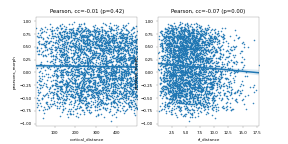

Text(0.5, 1.0, 'Pearson, cc=-0.07 (p=0.00)')

In [350]:
metric='pearsons'
y_var = '%s_morph' % metric
x_var = 'cortical_distance'
plotd=pw_df[pw_df.cortical_distance<500].copy().dropna()
scatter_kws={'s':2}
# -------------------
fig, axn = pl.subplots(1, 2, figsize=(6,3))
ax=axn[0]
sns.regplot(x=x_var, y=y_var, data=plotd, ax=ax, scatter_kws=scatter_kws)
r, p = spstats.pearsonr(plotd[x_var], plotd[y_var])
ax.set_title('Pearson, cc=%.2f (p=%.2f)' % (r, p))

x_var = 'rf_distance'
ax=axn[1]
sns.regplot(x=x_var, y=y_var, data=plotd, ax=ax, scatter_kws=scatter_kws)
r, p = spstats.pearsonr(plotd[x_var], plotd[y_var])
ax.set_title('Pearson, cc=%.2f (p=%.2f)' % (r, p))


In [317]:
import copy

In [352]:
df = pw_df.copy()
# Split distances into X um bins
ctx_step=25
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


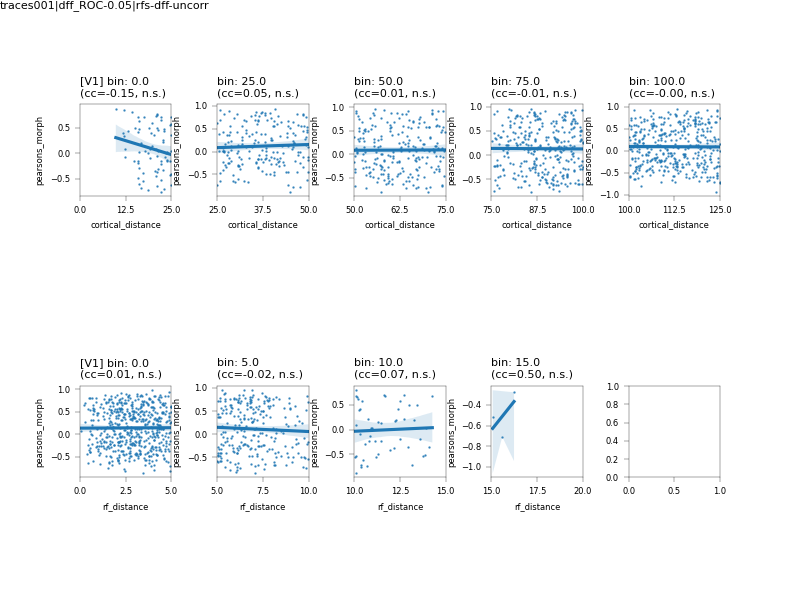

In [353]:
%matplotlib notebook
vg=df[(df.cortical_distance<200) ].copy()

y_var='pearsons_morph'
scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(2, n_bins_plot, figsize=(8,6), dpi=150)
fig.patch.set_alpha(1)
dist_var = 'cortical_distance'
for ri, dist_var in enumerate(['cortical_distance', 'rf_distance']):
    dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[ri, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %.1f\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')

for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)


In [354]:
plot_pairs = ['%i_%i' % tuple(rois_plot_mp)]
plot_pairs

['217_388']

In [388]:
max_resp = rdf.groupby('cell')['response'].max().reset_index()
top_rois = max_resp.sort_values(by='response', ascending=False)\
                   .iloc[0:20]['cell'].values
top_rois

array([388, 217, 381,  90, 417, 365,  62, 235,  37,   1, 405, 207,  65,
       385, 383,   0, 240, 139, 376, 377])

## Visualize traces

In [362]:
import analyze2p.extraction.traces as traceutils

In [363]:
data_fpath = traceutils.get_data_fpath(dk, experiment_name='blobs')
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected')
processed, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/data_arrays/corrected.npz
--- processed traces: dff


In [365]:
importlib.reload(traceutils)

<module 'analyze2p.extraction.traces' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/traces.py'>

In [389]:
# rid = 217
plot_rois = [217, 388]
t_list=[]
for rid in top_rois:
    best_sz = int(morph_curves[morph_curves['cell']==rid]['best_size'].unique())
    cfgs_ = sdf[(sdf['size']==best_sz) & sdf['morphlevel'].isin(morphlevels)]\
                .index.tolist()
    tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                    cfgs_, sdf[sdf.morphlevel.isin(morphlevels)], 
                    param='morphlevel', 
                    return_stacked=True, smooth=True, win_size=9)
    tdf['has_rfs'] = ~np.isnan(posdf_.loc[rid]['x0'])
    tdf['cell']=rid
    t_list.append(tdf)
trace_ex = pd.concat(t_list, axis=0)
trace_ex.head()

,time,morphlevel,mean,sem,has_rfs,cell
0,-1.007739,0,0.019395,0.029172,True,388
1,-0.985344,0,0.018302,0.028986,True,388
2,-0.962950,0,0.021999,0.028616,True,388
3,-0.940556,0,0.013419,0.029167,True,388
4,-0.918162,0,0.012186,0.028849,True,388


<IPython.core.display.Javascript object>


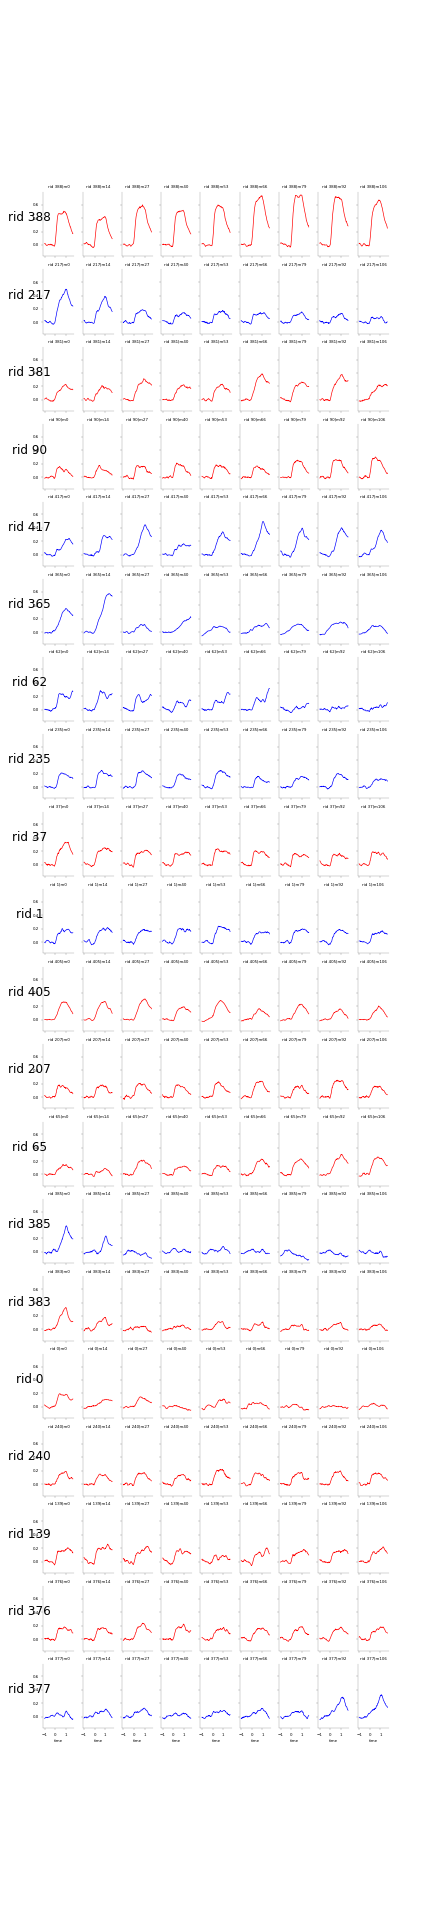

In [424]:
fg = sns.FacetGrid(data=trace_ex, col='morphlevel', col_order=morphlevels, 
               row='cell', row_order=top_rois, 
               hue='has_rfs', palette={True: 'r', False:'b'}, height=2, aspect=0.5)
fg.map(pl.plot, 'time', 'mean', lw=1)
fg.fig.patch.set_alpha(1)
fg.set_titles('rid {row_name}|m{col_name}', fontsize=18)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

for ax in fg.fig.axes:
    rname, mlevel = ax.get_title().split('|m')
    if int(mlevel)==0:
        ax.set_ylabel(rname,rotation=0, fontsize=18)

In [498]:

check_rois=sorted([381, 90, 65, 383, 388])
check_pairs = list(itertools.combinations(check_rois, 2))
check_pairs

[(65, 90),
 (65, 381),
 (65, 383),
 (65, 388),
 (90, 381),
 (90, 383),
 (90, 388),
 (381, 383),
 (381, 388),
 (383, 388)]

<IPython.core.display.Javascript object>


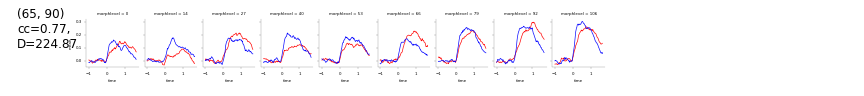

<IPython.core.display.Javascript object>


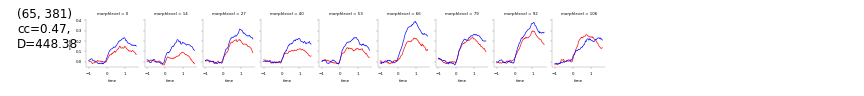

<IPython.core.display.Javascript object>


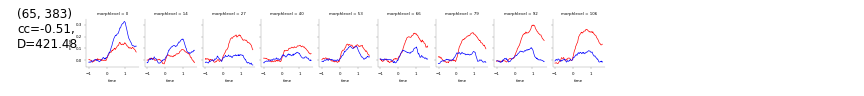

<IPython.core.display.Javascript object>


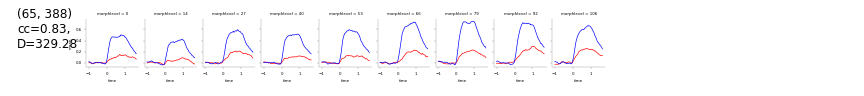

<IPython.core.display.Javascript object>


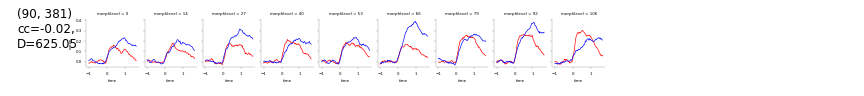

<IPython.core.display.Javascript object>


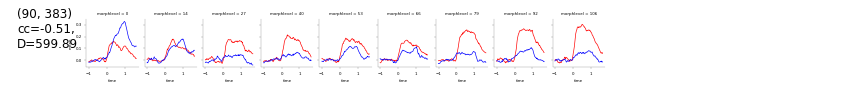

<IPython.core.display.Javascript object>


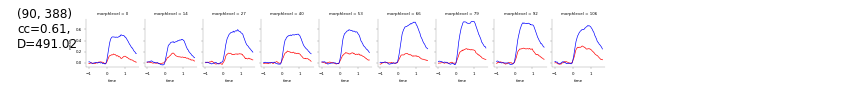

<IPython.core.display.Javascript object>


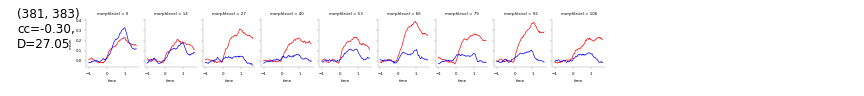

<IPython.core.display.Javascript object>


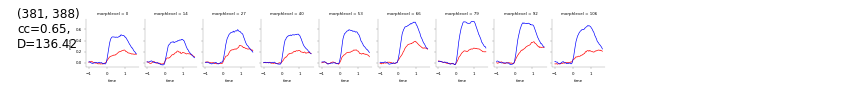

<IPython.core.display.Javascript object>


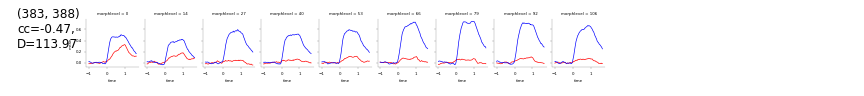

In [537]:
%matplotlib notebook
for cpair in check_pairs:
    r1, r2 = cpair
    rid_colors={r1: 'r', r2: 'b'}
    cc, dist = pw_df[pw_df['neuron_pair']=='%s_%i' % (r1, r2)]\
                [['pearsons_morph', 'cortical_distance']].values[0]
    t_=[]
    means_={}
    for rid in cpair:
        best_sz = int(morph_curves[morph_curves['cell']==rid]['best_size'].unique())
        cfgs_ = sdf[(sdf['size']==best_sz) & sdf['morphlevel'].isin(morphlevels)]\
                    .index.tolist()
        tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                        cfgs_, sdf[sdf.morphlevel.isin(morphlevels)], 
                        param='morphlevel', 
                        return_stacked=True, smooth=True, win_size=9)
        tdf['has_rfs'] = ~np.isnan(posdf_.loc[rid]['x0'])
        tdf['cell']=rid
        t_.append(tdf)
        meanr = trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
                        .groupby('config').mean()
        means_[rid] = meanr
    tdf = pd.concat(t_, axis=0).reset_index(drop=True)
    fg = sns.FacetGrid(data=tdf, col='morphlevel', col_order=morphlevels, 
                   height=2, aspect=1, hue='cell', palette=rid_colors)
    fg.map(pl.plot, 'time', 'mean', lw=1)
    fg.fig.patch.set_alpha(1)
    pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
    label = '%s\ncc=%.2f,\nD=%.2f' % (str(cpair), cc, dist)
    fg.fig.text(0.02, 0.5, label, fontsize=18)
    #fg.fig.axes[0].set_ylabel(str(cpair), fontsize=18, rotation=0)

## Compare w stim overlap

In [547]:
sdf_rf = aggr.get_stimuli(dk, experiment='rfs')
screen = hutils.get_screen_dims()
rfs= posdf_.copy()
rfs = rfs.rename(columns={'std_x': 'sigma_x', 'std_y':'sigma_y'})

In [560]:
images = su.load_stimuli()   
xp, yp = aggr.get_stimulus_coordinates(dk, 'blobs')


<IPython.core.display.Javascript object>


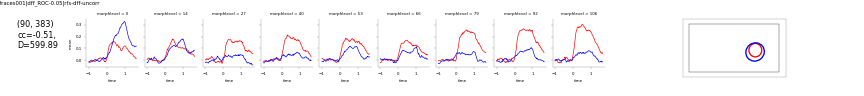

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples compare_rid90_383__V1_20190616_JC097_fov1


In [773]:
r1=90
r2=383
cpair = (r1, r2)

rid_colors={r1: 'r', r2: 'b'}
cc, dist = pw_df[pw_df['neuron_pair']=='%s_%i' % (r1, r2)]\
            [['pearsons_morph', 'cortical_distance']].values[0]
t_=[]
means_={}
for rid in cpair:
    best_sz = int(morph_curves[morph_curves['cell']==rid]['best_size'].unique())
    cfgs_ = sdf[(sdf['size']==best_sz) & sdf['morphlevel'].isin(morphlevels)]\
                .index.tolist()
    tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                    cfgs_, sdf[sdf.morphlevel.isin(morphlevels)], 
                    param='morphlevel', 
                    return_stacked=True, smooth=True, win_size=9)
    tdf['has_rfs'] = ~np.isnan(posdf_.loc[rid]['x0'])
    tdf['cell']=rid
    t_.append(tdf)
    meanr = trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
                    .groupby('config').mean()
    means_[rid] = meanr
tdf = pd.concat(t_, axis=0).reset_index(drop=True)
fg = sns.FacetGrid(data=tdf, col='morphlevel', col_order=morphlevels, 
               height=2, aspect=1, hue='cell', palette=rid_colors)
fg.map(pl.plot, 'time', 'mean', lw=1)
fg.fig.patch.set_alpha(1)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
    
# RFs
ax = fg.fig.add_axes([0.55, 0.2, 0.6, 0.6], polar=False)
pair_rfs = rfs[rfs.cell.isin(cpair)]
# plot_ori_hues = [ori_colordict[float(fits.loc[rid]['tested_theta'])] \
#                  for rid in cpair]
ax = rfutils.plot_rfs_to_screen_pretty(pair_rfs, sdf_rf, screen, 
                               fit_roi_list=cpair, ax=ax, 
                               roi_colors=[rid_colors[r] for r in cpair], 
                               ellipse_lw=2)

fg.fig.patch.set_alpha(1)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
label = '%s\ncc=%.2f,\nD=%.2f' % (str(cpair), cc, dist)
fg.fig.text(0.02, 0.5, label, fontsize=12)
    
pplot.label_figure(fg.fig, data_id)
figname = 'compare_rid%i_%i__%s_%s' % (r1, r2, va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

sz: (10.0, 50.0)
mp: (0, 106)


<IPython.core.display.Javascript object>


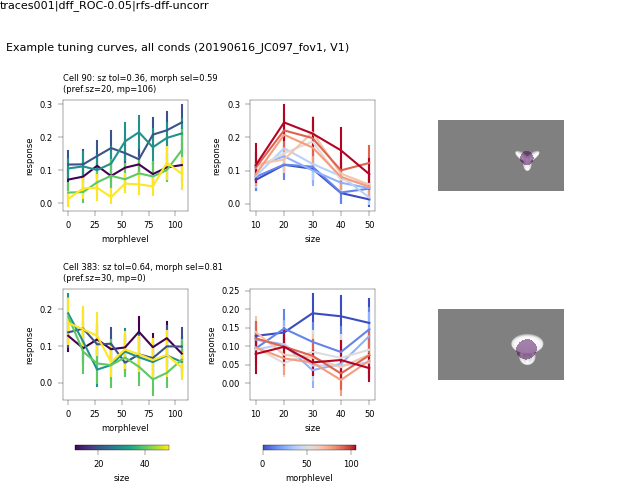

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples allconds_w_rfs_rid90_383__V1_20190616_JC097_fov1


In [774]:
size_lims = (min(sizes), max(sizes))
morph_lims = (min(morphlevels), max(morphlevels))
size_cmap= 'viridis'
morph_cmap = 'coolwarm'

print("sz: %s" % str(size_lims))
print("mp: %s" % str(morph_lims))

fig, axn = pl.subplots(2,len(plot_rois), figsize=(6.25, 5), dpi=150, sharey=False)
fig.patch.set_alpha(1)
for ai, rid in enumerate(cpair):
    roi_resp = x0[(x0.cell==rid)].copy()
    #for 
    best_sz = best_ixs.loc[rid]['best_size']
    best_mp = best_ixs.loc[rid]['best_morphlevel']
    # plot
    ax=axn[ai, 0]
    sns.lineplot(x='morphlevel', y='response', ax=ax,
                 data=roi_resp, err_style='bars', hue='size', palette=size_cmap)
    sel_v, tol_v = best_ixs.loc[rid][['morph_sel', 'size_tol']].values
    
    ax.set_title('Cell %i: sz tol=%.2f, morph sel=%.2f\n(pref.sz=%i, mp=%i)' \
                 % (rid, sel_v, tol_v, best_sz, best_mp), 
                 loc='left', fontsize=6)
    ax=axn[ai, 1]
    sns.lineplot(x='size', y='response',  ax=ax,
                data=roi_resp, err_style='bars', hue='morphlevel', palette=morph_cmap)

    rf_screen = su.rf_to_screen(rid, rfs[rfs['cell']==rid])
    rf_mask = rf_screen.astype(float).copy()
    rf_mask[rf_screen==0] = np.nan
    # Select stimulus and size
    ax=axn[ai, 2]
    mp= best_mp
    sz = best_sz
    stim = images['M%i' % mp].copy()
    stim_screen = su.draw_stimulus_to_screen(stim, size_deg=sz, stim_pos=(xp, yp))
    stim_mask = stim_screen.copy()
    stim_mask[stim_screen==0] = 0.3
    # plot
    ax.imshow(stim_mask, alpha=0.5, cmap='gray')
    ax.imshow(rf_mask, alpha=0.5)
    ax.invert_yaxis()
    ax.axis('off')

fig.subplots_adjust(bottom=0.2)

for hi, hue_var in enumerate(['size', 'morphlevel']):
    cbar_ax = fig.add_axes([0.12+(hi*0.3), 0.1, 0.15, 0.01])
    ax=axn[1, hi]
    cmap = size_cmap if hue_var=='size' else morph_cmap
    hue_min, hue_max = size_lims if hue_var=='size' else morph_lims
    ax.legend_.remove()
    hue_norm = pl.Normalize(hue_min, hue_max)
    sm = pl.cm.ScalarMappable(cmap=cmap, norm=hue_norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, cax=cbar_ax, 
                 orientation='horizontal', shrink=0.5, label=hue_var)
    axn[0, hi].legend_.remove()
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, hspace=0.7, top=0.8)
fig.text(0.01, 0.9, 'Example tuning curves, all conds (%s, %s)' \
         % (dk, va), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'allconds_w_rfs_rid%i_%i__%s_%s' % (r1, r2, va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

In [776]:
print(cpair)
best_ixs.loc[np.array(cpair)][['morph_sel', 'size_tol']]

(90, 383)


,morph_sel,size_tol
cell,,
90,0.357264,0.589258
383,0.643632,0.805507


In [777]:
stim_screen.min()

0.0

In [778]:
(sel_v, tol_v) = best_ixs.loc[np.array(cpair)][['morph_sel', 'size_tol']].values
print(sel_v, tol_v)

[0.35726391 0.58925821] [0.64363166 0.8055071 ]


In [779]:
plot_rois=[65, 90, 383]
plot_pairs = list(itertools.combinations(plot_rois, 2))

plot_pair_labels = ['%i_%i' % (r1, r2) for (r1, r2) in plot_pairs]
plot_pair_labels

['65_90', '65_383', '90_383']

<IPython.core.display.Javascript object>


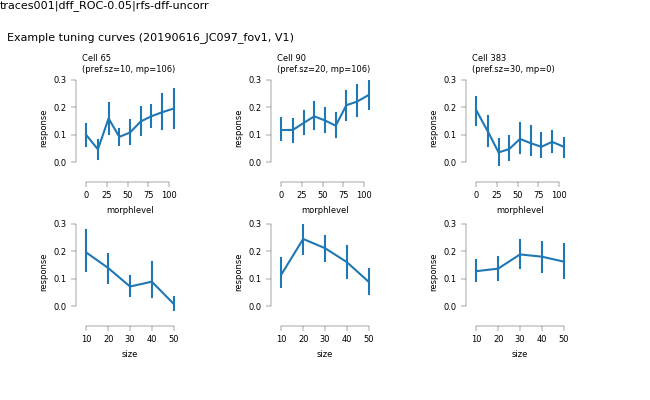

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples tuning_curves_examples__V1_20190616_JC097_fov1


In [780]:
fig, axn = pl.subplots(2,len(plot_rois), figsize=(6.5, 4), dpi=150, sharey=False)
fig.patch.set_alpha(1)
for ai, rid in enumerate(plot_rois):
    roi_resp = x0[(x0.cell==rid)].copy()
    best_sz = best_ixs.loc[rid]['best_size']
    best_mp = best_ixs.loc[rid]['best_morphlevel']
    # plot
    ax=axn[0, ai]
    sns.lineplot(x='morphlevel', y='response', ax=ax,
                 data=roi_resp[roi_resp['size']==best_sz], err_style='bars')
    ax.set_title('Cell %i\n(pref.sz=%i, mp=%i)' % (rid, best_sz, best_mp), 
                 loc='left', fontsize=6)
    ax=axn[1, ai]
    sns.lineplot(x='size', y='response',  ax=ax,
                data=roi_resp[roi_resp['morphlevel']==best_mp], err_style='bars')
for ax in axn.flat:
    ax.set_ylim([-0.05, 0.3])
    ax.set_yticks(np.linspace(0, 0.3, 4))
    ax.set_box_aspect(1)
sns.despine(trim=True, offset=4)
fig.text(0.01, 0.9, 'Example tuning curves (%s, %s)' % (dk, va), fontsize=8)
pl.subplots_adjust(left=0.1, right=0.9,bottom=0.2, wspace=0.5, top=0.8, hspace=0.5)

pplot.label_figure(fig, data_id)
figname = 'tuning_curves_examples__%s_%s' % (va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

In [40]:
pw_df[pw_df['neuron_pair'].isin(plot_pair_labels)]

NameError: name 'pw_df' is not defined

In [797]:

ctx_maxdist = 1000
ctx_step = 50
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = pw_df[pw_df.cortical_distance<=ctx_maxdist].copy().dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.05
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2.5
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')



<IPython.core.display.Javascript object>


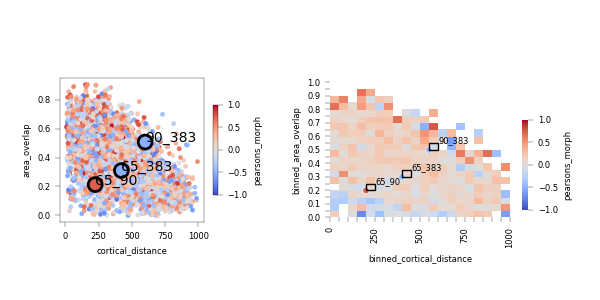

In [888]:
%matplotlib notebook
markersize = 10

plot_pairs =plot_pairs
x_var = 'cortical_distance'
y_var = 'area_overlap'

x_var_name = 'binned_%s' % x_var
y_var_name = 'binned_%s' % y_var
x_vals = [k for k, v in plotd.groupby(x_var_name)]
y_vals = [k for k, v in plotd.groupby(y_var_name)]

plotd['%s_index' % x_var_name] = [x_vals.index(i) for i \
                                    in plotd[x_var_name]]
plotd['%s_index' % y_var_name] = [y_vals.index(i) for i \
                                    in plotd[y_var_name]]

x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()

hue_var = 'pearsons_morph'
hue_min, hue_max = (-1, 1)
cmap='coolwarm'
#
fig, axn = pl.subplots(1,2, figsize=(6,3), dpi=150)
fig.patch.set_alpha(1)
ax=axn[0]
sns.scatterplot(x=x_var, y=y_var, data=plotd, ax=ax,
                hue=hue_var, hue_norm=(hue_min, hue_max), palette=cmap, 
                edgecolor=None, s=markersize)
sns.scatterplot(x=x_var, y=y_var, 
                data=plotd[plotd['neuron_pair'].isin(plot_pair_labels)], ax=ax,
                hue=hue_var, hue_norm=(hue_min, hue_max), palette=cmap,
                edgecolor='k', linewidth=2,  s=100)
for currpair in plot_pair_labels:
    if currpair not in plotd.neuron_pair.values:
        print("   missing %s" %currpair)
        continue
    x=float(plotd[(plotd.neuron_pair==currpair)][x_var])
    y=float(plotd[(plotd.neuron_pair==currpair)][y_var])
    ax.text(x, y, currpair)
ax.legend_.remove()
norm = pl.Normalize(hue_min, hue_max)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label=hue_var)
ax.set_box_aspect(1)

# binned
ax=axn[1]
cbar_ax = fig.add_axes([0.87, 0.3, 0.01, 0.3])
means_ = plotd.groupby([y_var_name, x_var_name])\
           .mean().reset_index()
hmat = means_.pivot(y_var_name, x_var_name, hue_var)
sns.heatmap(hmat, cmap='coolwarm', ax=ax, vmin=hue_min, vmax=hue_max,
            cbar=1, cbar_ax=cbar_ax, cbar_kws={'label': hue_var}) 
#, center=0)
ax.set_box_aspect(0.75)
ax.set_yticks(np.arange(0, len(y_bins)))
ax.set_yticklabels([round(i, 2) if i in y_bins[0::2] else '' for i in y_bins])
ax.set_xticks(np.arange(0, len(x_bins)))
ax.set_xticklabels([int(i) if i in x_bins[0::5] else '' for i in x_bins])

sns.scatterplot(x='%s_index' % x_var_name, y='%s_index' % y_var_name, 
               hue=hue_var, ax=ax,
               data=plotd[plotd.neuron_pair.isin(plot_pair_labels)],
               s=20, palette=cmap, hue_norm=(hue_min, hue_max))
ax.invert_yaxis()
ax.legend_.remove()

for currpair in plot_pair_labels:
    row_v = float(plotd[plotd.neuron_pair==currpair][y_var_name])
    col_v =  float(plotd[plotd.neuron_pair==currpair][x_var_name])
    xv_, yv_, = x_vals.index(col_v), y_vals.index(row_v)
    hv_ = float(plotd[plotd.neuron_pair==currpair][y_var])
    ax.add_patch(mpl.patches.Rectangle((xv_, yv_), 1, 1, 
                                       fill=False, edgecolor='k', lw=1))

#     sns.scatterplot(x=x_var_name, y=y_var_name, hue=hue_var, 
#                    data=plotd[plotd.neuron_pair.isin(plot_pair_labels)], ax=ax,
#                    size=20)
#     sns.scatterplot(x=[xv_+0.5], y=[yv_+0.5], 'o', mec='k', mfc=None,
#            color=hv_, )
    ax.text(xv_+1, yv_+1, currpair, size=6)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)


In [835]:
#currpair = plot_pair_labels[0]
row_v = float(plotd[plotd.neuron_pair==currpair]['binned_%s' % y_var])
col_v =  float(plotd[plotd.neuron_pair==currpair]['binned_%s' % x_var])

xv_, yv_, = x_vals.index(col_v), y_vals.index(row_v)

print(col_v, row_v)
plotd[plotd.neuron_pair==currpair]

550.0 0.5


,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response,...,rf_angle_diff_abs,std_x,std_y,aspect_ratio,binned_cortical_distance,cortical_distance_label,binned_area_overlap,area_overlap_label,binned_rf_distance,rf_distance_label
6255,2.439347,-0.505153,0.790064,90,383,90_383,2.982007,0.991866,0.981519,0.056297,...,52.460369,2.520315,2.677169,0.337169,550,550.0,0.5,0.5,0.0,0.0


In [943]:
ctx_maxdist = 1000
ctx_step = 50
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = pw_df[pw_df.cortical_distance<=ctx_maxdist].copy().dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.05
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')


-0.7094145887823786 0.7833221809841509


<IPython.core.display.Javascript object>


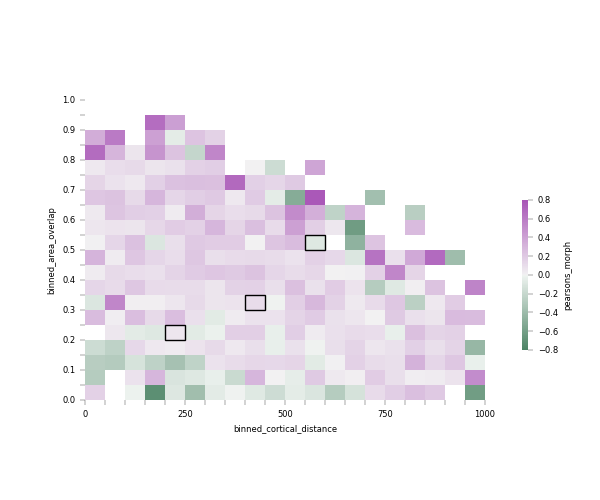

In [993]:
%matplotlib notebook
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons_morph'
hue_min, hue_max = (-.8, 0.8)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
#'coolwarm'

# x_var_name = 'binned_%s' % x_var
# y_var_name = 'binned_%s' % y_var
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var
x_vals = [k for k, v in plotd.groupby(x_var_name)]
y_vals = [k for k, v in plotd.groupby(y_var_name)]
plotd['%s_index' % x_var_name] = [x_vals.index(i) for i \
                                    in plotd[x_var_name]]
plotd['%s_index' % y_var_name] = [y_vals.index(i) for i \
                                    in plotd[y_var_name]]

grouped_hue_min = plotd.groupby([x_var_name, y_var_name])[hue_var].mean().min()
grouped_hue_max = plotd.groupby([x_var_name, y_var_name])[hue_var].mean().max()
print(grouped_hue_min, grouped_hue_max)
x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
#
fig, ax = pl.subplots(figsize=(6, 5), dpi=150)
fig.patch.set_alpha(1)
cbar_ax = fig.add_axes([0.87, 0.3, 0.01, 0.3])
means_ = plotd.groupby(['binned_%s' % y_var, 'binned_%s' % x_var])\
           .mean().reset_index()
hmat = means_.pivot('binned_%s' % y_var, 'binned_%s' % x_var, hue_var)
sns.heatmap(hmat, cmap=cmap, ax=ax, vmin=hue_min, vmax=hue_max,
            cbar=1, cbar_ax=cbar_ax, cbar_kws={'label': hue_var}) 
ax.set_box_aspect(0.75)
#, center=0)
ax.set_box_aspect(0.75)
ax.set_yticks(np.arange(0, len(y_bins)))
ax.set_yticklabels([round(i, 2) if i in y_bins[0::2] else '' for i in y_bins])
ax.set_xticks(np.arange(0, len(x_bins)))
ax.set_xticklabels([int(i) if i in x_bins[0::5] else '' for i in x_bins])
ax.invert_yaxis()
# 
for currpair in plot_pair_labels:
    row_v = float(plotd[plotd.neuron_pair==currpair][y_var_name])
    col_v =  float(plotd[plotd.neuron_pair==currpair][x_var_name])
    xv_, yv_, = x_vals.index(col_v), y_vals.index(row_v)
    hv_ = float(plotd[plotd.neuron_pair==currpair][y_var])
    ax.add_patch(mpl.patches.Rectangle((xv_, yv_), 1, 1, 
                                       fill=False, edgecolor='k', lw=1))
    
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)


In [738]:

ctx_maxdist = 500
ctx_step = 25
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = pw_df[pw_df.cortical_distance<=ctx_maxdist].copy() #.dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.1
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2.5
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')



<IPython.core.display.Javascript object>


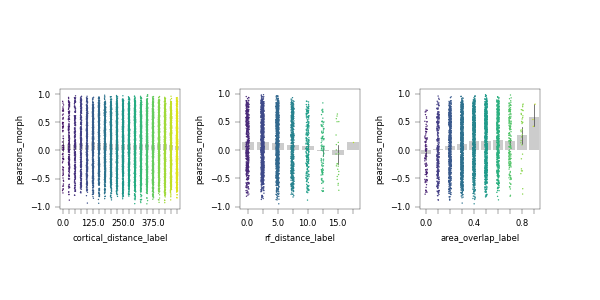

In [739]:
dist_params = ['cortical_distance', 'rf_distance', 'area_overlap']
    
fig, axn = pl.subplots(1, len(dist_params), figsize=(6,3), dpi=150)
fig.patch.set_alpha(1)
# sns.scatterplot(x='area_overlap', y='pearsons_morph', data=plotd, ax=ax)
# sns.barplot(x='area_overlap_label', y='pearsons_morph', data=plotd, ax=ax)
# sns.stripplot(x='area_overlap_label', y='pearsons_morph', data=plotd, ax=ax,
#              size=5)
for ax, x_v in zip(axn.flat, dist_params):
#     sns.boxplot(x='%s_label' % x_v, y='pearsons_morph', data=plotd, ax=ax, 
#            whis=(5, 95), fliersize=0)
    sns.barplot(x='%s_label' % x_v, y='pearsons_morph', data=plotd, ax=ax,
               ci=95, errwidth=0.5, color=[0.8]*3)
    sns.stripplot(x='%s_label' % x_v, y='pearsons_morph', data=plotd, ax=ax,s=1,
                 palette='viridis')
    ax.set_box_aspect(1)
    x_vals = [k for k, v in plotd.groupby(['%s_label' % x_v])]
    
    #x_vals = sorted([round(i, 1) for i in plotd['%s_label' % x_v].unique()])
    ax.set_xticks(np.arange(0, len(x_vals)))
    round_to = 2 if x_v =='area_overlap' else 0
    if x_v == 'cortical_distance':
        skip_x = 5
    else:
        skip_x = 2 if x_v=='rf_distance' else 4
    ax.set_xticklabels([round(i,round_to) if i in x_vals[0::skip_x] \
                        else '' for i in x_vals])
pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5)

In [742]:

ctx_maxdist = 500
ctx_step = 25
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = pw_df[pw_df.cortical_distance<=ctx_maxdist].copy().dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.1
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2.5
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')


In [745]:
plotd.dtypes

xcorr_morph                  float64
pearsons_morph               float64
cosim_morph                  float64
cell_1                         int64
cell_2                         int64
neuron_pair                   object
xcorr_size                   float64
pearsons_size                float64
cosim_size                   float64
max_response                 float64
rf_distance                  float64
max_ecc                      float64
min_ecc                      float64
cortical_distance            float64
area_overlap                 float64
perc_overlap                 float64
rf_angle_diff                float64
rf_angle_diff_abs            float64
std_x                        float64
std_y                        float64
aspect_ratio                 float64
binned_cortical_distance    category
cortical_distance_label      float64
binned_area_overlap         category
area_overlap_label           float64
binned_rf_distance          category
rf_distance_label            float64
d

<IPython.core.display.Javascript object>


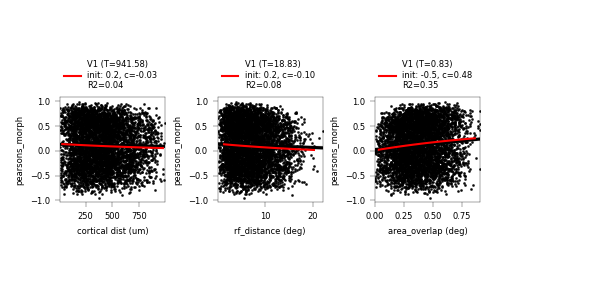

In [994]:
%matplotlib notebook
metric='pearsons_morph'
params = ['cortical_distance', 'rf_distance', 'area_overlap']
fit_sites = False
use_binned=True
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)


fig, axn = pl.subplots(1, len(params), figsize=(6,3), dpi=150)
fig.patch.set_alpha(1)

for ax, to_quartile in zip(axn.flat, params):
    xlabel='cortical dist (um)' if to_quartile=='cortical_distance' else '%s (deg)' % to_quartile

    if fit_sites:
        cnt_grouper.append('datakey')
    x_var = '%s_label' % to_quartile
    cnt_grouper = [x_var] 

    cnts = plotd.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in plotd.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()

    # plot
    meas_cc = plotd.groupby(cnt_grouper).median().reset_index().dropna()
    #ax.scatter(x=to_quartile, y=metric, data=plotd, s=2, color='k')
    sns.regplot(x=to_quartile, y=metric, data=plotd, color='k',
               scatter_kws={'s':1}, ax=ax)
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
    ax.set_box_aspect(1)
    #ax.set_xlim([0, 250])
#ax.set_ylim([0, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7, wspace=0.5)

In [950]:
import tifffile as tf
import analyze2p.retinotopy.utils as retutils

In [951]:

session, animalid, fovnum = hutils.split_datakey_str(dk)
tfs = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovnum,
                      'blobs_run1', 'processed/processed*', 
                    'mcorrected*_deinterleaved', 'Channel01', 'File*', '*.tif'))
i_=[]
for t in tfs:
    im = tf.imread(t)
    i_.append(im)
imstack = np.dstack(i_)

<IPython.core.display.Javascript object>


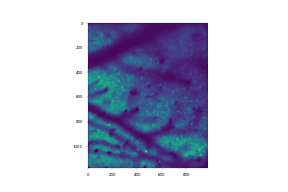

In [952]:
meanr = imstack.mean(axis=-1)
pixel_size = hutils.get_pixel_size()  
fov_transformed = retutils.transform_2p_fov(meanr, pixel_size, normalize=True)

zimg_r = pplot.adjust_image_contrast(fov_transformed, clip_limit=5.0, tile_size=5)
pl.figure()
pl.imshow(zimg_r)

<IPython.core.display.Javascript object>


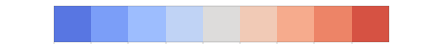

In [954]:
morph_colormap='coolwarm'
morph_colors = sns.color_palette(morph_colormap, n_colors=len(morphlevels))
sns.palplot(sns.color_palette(morph_colormap, n_colors=len(morphlevels)))

In [964]:
best_ixs.index.name=None
best_ixs.head()
best_ixs['visual_area'] = va
best_ixs['datakey'] = dk
best_ixs['experiment'] = 'blobs'
ixs_pos = aggr.add_roi_positions(best_ixs)


<IPython.core.display.Javascript object>


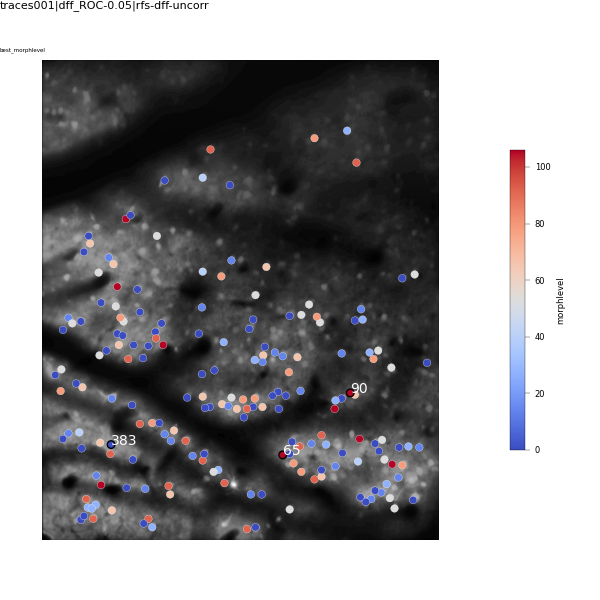

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples fov_overlay_hue-morphlevel__V1_20190616_JC097_fov1_labeled


<IPython.core.display.Javascript object>


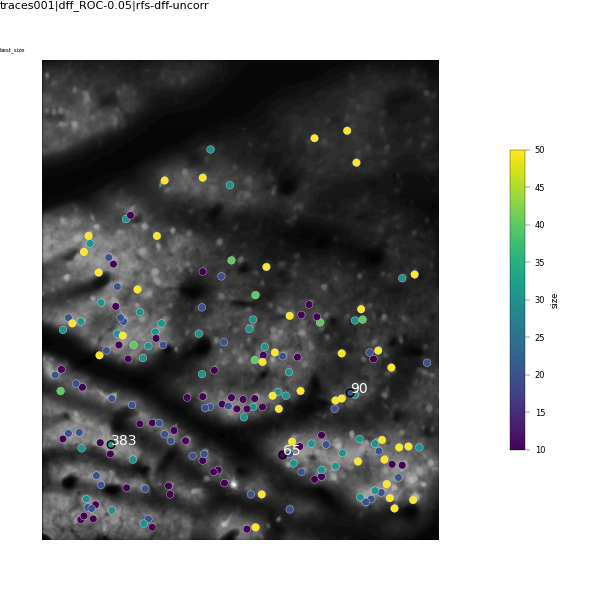

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/examples fov_overlay_hue-size__V1_20190616_JC097_fov1_labeled


In [989]:
hue_var='morphlevel'

label_rois=True

for hue_var in ['morphlevel', 'size']:
    hue_levels = morphlevels if hue_var=='morphlevel' else sizes
    hue_min, hue_max = min(hue_levels), max(hue_levels)
    cmap=morph_cmap if hue_var =='morphlevel' else size_cmap
    norm = pl.Normalize(hue_min, hue_max)

    fig = pl.figure(figsize=(6,6), dpi=150, frameon=False)
    ax = pl.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    fig.patch.set_alpha(1)

    ax.imshow(zimg_r, cmap='gray', alpha=1 if label_rois else 0)
    sns.scatterplot(x='ml_pos', y='ap_pos', data=ixs_pos, ax=ax,
                    hue='best_%s' % hue_var, palette=cmap,hue_norm=(hue_min, hue_max),
                    s=30,linewidth=0.2)
    ax.legend_.remove()
    ax.axis('off')
    if label_rois is True:
        for rid in plot_rois:
            ax.text(ixs_pos.loc[rid]['ml_pos'], ixs_pos.loc[rid]['ap_pos'], int(rid), 
                    fontsize=10, color='w')
    if label_rois:
        ax.set_title('best_%s' % hue_var, fontsize=4, loc='left')
        pplot.label_figure(fig, data_id)
        sns.scatterplot(x='ml_pos', y='ap_pos',
                        data=ixs_pos[ixs_pos['cell'].isin(plot_rois)], ax=ax,
                        hue='best_%s' % hue_var, palette=cmap, 
                        hue_norm=(hue_min, hue_max),
                        s=30,linewidth=1, edgecolor='k')
        ax.legend_.remove()

    sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label=hue_var)
    ax.set_box_aspect(1)

    figname='fov_overlay_hue-%s__%s_%s' % (hue_var, va, dk) 
    if label_rois:
        figname='%s_labeled' % figname
    pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
    print(examples_dir, figname)


In [971]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/signal_correlations/ROC_rfs-dff-uncorr/examples'

In [465]:
currpair

'37_383'

In [731]:
plotd[plotd['neuron_pair'].isin(plot_pairs)]

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response,...,rf_angle_diff_abs,std_x,std_y,aspect_ratio,binned_cortical_distance,cortical_distance_label,binned_area_overlap,area_overlap_label,binned_rf_distance,rf_distance_label


# Aggregate

In [528]:
response_type='dff'
do_spherical_correction=False
# ------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [122]:
print(rf_fit_desc)
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

NameError: name 'rf_fit_desc' is not defined

In [492]:
# va='V1'
# dk='20190616_JC097_fov1'
offset_type='minsub' 
lcorrection='exclude'
with_lum = False

rdf_list=[]
for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):

    sdf = aggr.get_stimuli(dk, experiment, match_names=True)
    if with_lum:
        configs = sdf.index.tolist()
    else:
        configs = sdf[sdf['morphlevel']!=-1].index.tolist()
    sizes = list(sorted(sdf['size'].unique()))
    morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
    # print(morphlevels)

    x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
              & (NDATA0.config.isin(configs))].copy()
    rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config'])\
             .mean().reset_index().drop('trial', axis=1)
    rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
    rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
    rdf['size'] = sdf.loc[rdf['config']]['size'].values
    rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values

    rdf_list.append(rdf)
avg_responses = pd.concat(rdf_list, axis=0, ignore_index=True)
avg_responses['experiment'] = 'blobs'

In [501]:
has_rfs = pd.concat([g for (va, dk), g in rfdf.groupby(['visual_area', 'datakey'])
                    if not avg_responses.query('@va==visual_area')])

,visual_area,datakey,cell,config,response,size,morphlevel,experiment
0,Li,20190315_JC070_fov1,145,config006,0.045293,10.0,0,blobs
1,Li,20190315_JC070_fov1,145,config007,0.034502,20.0,0,blobs
2,Li,20190315_JC070_fov1,145,config008,0.029531,30.0,0,blobs
3,Li,20190315_JC070_fov1,145,config009,0.040361,40.0,0,blobs
4,Li,20190315_JC070_fov1,145,config010,0.030793,50.0,0,blobs


In [527]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [529]:

DISTS = cr.aggregate_tuning_curve_ccdist(avg_responses, rfdf=rfdf, 
                                         min_ncells=5, stimulus='blobs')

too few cells: Li, 20190319_JC067_fov1
too few cells: Li, 20190320_JC067_fov1
too few cells: Li, 20190321_JC070_fov1
too few cells: Lm, 20191111_JC120_fov1
[]


In [531]:
DISTS.groupby('visual_area').count()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance,datakey,n_cells
visual_area,,,,,,,,,,,,,,,
Li,10770,10770,10770,10770,10770,10770,10770,10770,10770,1940,1940,1940,10770,10770,10770
Lm,28864,28864,28864,28864,28864,28864,28864,28864,28864,2463,2463,2463,28864,28864,28864
V1,74551,74551,74551,74551,74551,74551,74551,74551,74551,18307,18307,18307,74551,74551,74551


In [532]:
va='V1'
dk='20190616_JC097_fov1'
test_a = DISTS[(DISTS.visual_area==va) & (DISTS.datakey==dk)].copy()
test_a.shape, adist.shape

((17020, 16), (17020, 13))

In [533]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


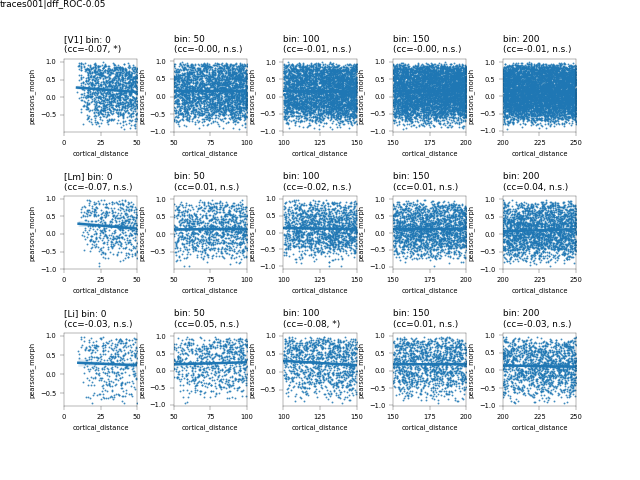

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning pearsons_morph_v_binCTX_50um


In [585]:
%matplotlib notebook
y_var='pearsons_morph'
dist_var = 'cortical_distance'
# -------------------------------------------------------------
dist_str='VF' if dist_var=='rf_distance' else 'CTX'
dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
dist_step = rf_step if dist_var=='rf_distance' else ctx_step
dist_unit = 'deg' if dist_var=='rf_distance' else 'um'
#
scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,6))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_bin%s_%i%s' % (y_var, dist_str, dist_step, dist_unit)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [591]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


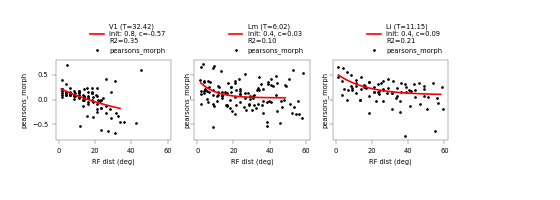

In [597]:
%matplotlib notebook
metric='pearsons_morph'
to_quartile = 'rf_distance'
x_var = '%s_label' % to_quartile

fit_sites = True
use_binned=False
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)

xlabel='cortical dist (um)' if to_quartile=='cortical_distance' else 'RF dist (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
   
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index().dropna()
    ax.scatter(x=to_quartile, y=metric, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
       #ax.set_title(va)
    #ax.set_xlim([0, 250])
   # ax.set_xlim([0, 40])
    #ax.set_ylim([0, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [559]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning'

In [516]:
va='V1'
dk='20190616_JC097_fov1'
df_ = avg_responses[(avg_responses.visual_area==va) & (avg_responses.datakey==dk)]

In [519]:

posdf_ = aggr.add_roi_positions(df_)
if rfdf is not None:
    posdf0 = posdf_.copy()
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf_ = cr.get_roi_pos_and_rfs(posdf0, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if posdf_.shape[0]==0:
        print(va, dk)

In [520]:
posdf_

,visual_area,datakey,cell,ml_pos,ap_pos,x0,y0
0,V1,20190616_JC097_fov1,0,909.977299,1078.506458,34.263130,-10.628686
1,V1,20190616_JC097_fov1,1,864.288063,1099.246967,NaN,NaN
2,V1,20190616_JC097_fov1,2,852.865753,1073.897456,30.848143,-6.732552
3,V1,20190616_JC097_fov1,9,873.806654,1023.198434,39.429009,-3.330024
4,V1,20190616_JC097_fov1,11,883.325245,993.239922,35.470047,-12.506376
...,...,...,...,...,...,...,...
180,V1,20190616_JC097_fov1,424,207.505284,1048.547945,29.780096,-2.802732
181,V1,20190616_JC097_fov1,425,32.363209,772.007828,20.431419,-7.071060
182,V1,20190616_JC097_fov1,426,45.689237,811.184344,NaN,NaN
183,V1,20190616_JC097_fov1,429,138.971429,520.817221,20.485330,-13.131780


In [524]:

cc = cr.get_pw_curve_correlations(df_, stimulus='blobs')
diffs_ = cc.copy()

if 'x0' in posdf_.columns:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)


In [526]:
adist.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029,NaN,NaN,NaN,50.176439
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413,5.180927,35.873821,31.574280,57.297221
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813,8.941855,39.569379,35.873821,66.085498
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303,2.232122,37.610287,35.873821,89.334843
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609,9.247455,40.524749,35.873821,129.947597


In [486]:
no_rfs=[]

curr_rfs=None
if rfdf is not None:
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf = cr.get_roi_pos_and_rfs(df_, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if curr_rfs.shape[0]==0:
        no_rfs.append((va, dk, exp))
else:
    posdf = aggr.add_roi_positions(df_)
no_rfs

[]

In [490]:
posdf_ = aggr.add_roi_positions(df_)
posdf_

,visual_area,datakey,cell,config,response,size,morphlevel,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,V1,20190616_JC097_fov1,0,config006,0.073549,10.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
1,V1,20190616_JC097_fov1,0,config007,0.062874,20.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
2,V1,20190616_JC097_fov1,0,config008,0.089596,30.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
3,V1,20190616_JC097_fov1,0,config009,0.102889,40.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
4,V1,20190616_JC097_fov1,0,config010,0.181599,50.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8320,V1,20190616_JC097_fov1,431,config046,0.047672,10.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8321,V1,20190616_JC097_fov1,431,config047,0.014780,20.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8322,V1,20190616_JC097_fov1,431,config048,0.016424,30.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8323,V1,20190616_JC097_fov1,431,config049,0.016479,40.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890


In [ ]:

cc = get_pw_curve_correlations(df_, n_intervals=n_intervals, stimulus=stimulus)
diffs_ = cc.copy()

# # Cortical and RF difff
# if 'ml_pos' not in df_.columns:
#     if stimulus=='blobs':
#         posdf0 = df_[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
#     else:
#         posdf0 = df_.copy()
#     posdf_ = aggr.add_roi_positionsS(posdf0)
# else:
#     posdf_ = df_.copy()        

if 'x0' in posdf_.columns:
    adist = get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)

assert adist.shape[0]==cc.shape[0], 'Bad merging: %s, %s' (va, dk)